Connected to evolutionalnn-ww6wOzNP-py3.10 (Python 3.10.12)

In [1]:
import jax 
jax.config.update("jax_enable_x64", False)
#jax.config.update("jax_debug_nans", True)
import equinox as eqx
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from typing import NamedTuple, Callable, Container
import abc
from tqdm.auto import tqdm
from tqdm import trange
import optax
import matplotlib.pyplot as plt
from functools import partial
import diffrax as dfx
import jaxopt

class Data(NamedTuple):
    x: jnp.ndarray
    y: jnp.ndarray

class PDE(eqx.Module):
    params: jnp.ndarray # parameters of the PDE
    xspan: jnp.ndarray # spatial domain
    tspan: jnp.ndarray # time domain
    @abc.abstractmethod
    def init_func(self, x):
        raise NotImplementedError
    @abc.abstractmethod
    def boundary_func(self, x):
        raise NotImplementedError
    @abc.abstractmethod
    def spatial_diff_operator(self, u_func): # u(x, )
        raise NotImplementedError

class ParabolicPDE2D(PDE):
    params: jnp.ndarray #[v]
    xspan: jnp.ndarray # spatial domain [[x_low, y_low], [x_high, y_high]]
    tspan: jnp.ndarray # time domain
    
    def init_func(self, x):
        return jnp.sin(x[0])* jnp.sin(x[1])
    
    def boundary_func(self, x):
        return jnp.array(0.)
    
    def spatial_diff_operator(self, func:Callable[[jnp.ndarray], float]): # u(x,y)-> u

        u_func = lambda x,y: jnp.sum(func(jnp.array([x,y])))

        ux = jax.grad(u_func, argnums=0)
        uxx = jax.grad(ux, argnums=0)
        uy = jax.grad(u_func, argnums=1)
        uyy = jax.grad(uy, argnums=1)
        v = self.params[0]
        Nx_func = lambda X: (uxx(X[0],X[1]) + uyy(X[0],X[1])) * v 
        return Nx_func
    
    def u_true(self, x, t):
        # Analytical solution: sin(x)sin(y)exp(-2vt)
        return jnp.sin(x[0]) * jnp.sin(x[1]) * jnp.exp(-2 * self.params[0] * t)

class Sampler(eqx.Module):
    pde: PDE
    batch: int
    samp_init: Callable[[jr.PRNGKey], Data]
    def __init__(self, pde, batch):
        self.pde = pde
        self.batch = batch
        dim = pde.xspan.shape[1]
        
        def samp_init(key):
            x = jr.uniform(key, (batch, dim), minval=self.pde.xspan[0], maxval=self.pde.xspan[1])
            y = jax.vmap(self.pde.init_func)(x)
            return Data(x,y)
        
        self.samp_init = jax.jit(samp_init)

class NNconstructor(eqx.Module):
    param_restruct: Callable[[jnp.ndarray], jnp.ndarray]
    nn_static: eqx.Module
    filter_spec: Container # spec for time evolution

    def __call__(self, W):
        nn_param = self.param_restruct(W)
        nn = eqx.combine(nn_param, self.nn_static)
        return nn

    def get_w(self, nn):
        nn_param, nn_static = eqx.partition(nn, self.filter_spec)
        W, param_restruct = jax.flatten_util.ravel_pytree(nn_param)
        return W

class EvolutionalNN(eqx.Module):
    W: jnp.ndarray
    pde: PDE
    nnconstructor: NNconstructor
    get_N: Callable[[jnp.ndarray, jnp.ndarray], jnp.ndarray]
    get_J: Callable[[jnp.ndarray, jnp.ndarray], jnp.ndarray]
    get_gamma: Callable[[jnp.ndarray, jnp.ndarray], jnp.ndarray]
    
    @classmethod
    def from_nn(cls, nn, pde, filter_spec=eqx.is_array):
        nn_param, nn_static = eqx.partition(nn, filter_spec)
        W, param_restruct = jax.flatten_util.ravel_pytree(nn_param)
        nnconstructor = NNconstructor(param_restruct, nn_static, filter_spec)

        @jax.jit
        def ufunc(W, xs):
            _nn = nnconstructor(W)
            u = lambda x: jnp.sum(_nn(x))
            us = jax.vmap(u)(xs)
            return us   # u(W, x)
        
        Jf =  jax.jacfwd(ufunc, argnums=0)

        @jax.jit
        def get_N(W, xs): #[batch, dim]
            # Spatial differential operator
            _nn = nnconstructor(W)
            nop = pde.spatial_diff_operator(_nn)
            return jax.vmap(nop)(xs)
        
        @jax.jit
        def get_J(W, xs):
            J = Jf(W, xs)
            return J

        # Define gamma method
        @jax.jit        
        def get_gamma(W, xs, tol=1e-5, **kwags):
            J = get_J(W, xs)
            N = get_N(W, xs)
            matvec = lambda x: jnp.dot(J.T @ J, x)
            gamma = jaxopt.linear_solve.solve_normal_cg(matvec, J.T @ N, tol=1e-5, **kwags)
            return gamma
            

        return cls(W, pde, nnconstructor, get_N, get_J, get_gamma)
    
    def new_w(self, W):
        return EvolutionalNN(W, self.pde, self.nnconstructor, self.get_N, self.get_J, self.get_gamma)

    def get_nn(self):
        return self.nnconstructor(self.W)
    
    def fit_initial(self, nbatch: int, nstep:int, optimizer, key: jr.PRNGKey, filter_spec=eqx.is_array, tol:float=1e-8):
        nn = self.get_nn()
        state = optimizer.init(eqx.filter(nn, filter_spec))
        sampler = Sampler(self.pde, nbatch)

        iter_step = trange(nstep)
        for i in iter_step:
            k_batch, key = jr.split(key)
            data = sampler.samp_init(k_batch) # sample initial function
            nn, state, loss = update_fn(nn, data, optimizer, state)
            iter_step.set_postfix({'loss':loss})
            if loss < tol:
                break
        return self.from_nn(nn, self.pde, self.nnconstructor.filter_spec)

    def ode (self, t,y, args):
        #jax.debug.print("y : {y}", y=y)
        gamma = self.get_gamma(y, xs)
        #jax.debug.print("Gamma : {gamma}", gamma=gamma)
        return gamma


@eqx.filter_jit
def update_fn(nn: eqx.Module, data:Data, optimizer, state):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(nn, data)
    updates, new_state = optimizer.update(grad, state, nn)
    new_nn = eqx.apply_updates(nn, updates)
    return new_nn, new_state, loss

def loss_fn(nn, data:Data):
    y_preds = jax.vmap(nn)(data.x)
    return jnp.mean(jnp.square(y_preds.ravel() - data.y.ravel()))


@eqx.filter_jit
def loop2d(arr1, arr2, fun):
    funcex = jax.jit(lambda x,y: fun(jnp.stack([x,y])))
    fj = jax.vmap(funcex, in_axes=(0,0))
    fi = jax.vmap(fj, in_axes=(0,0))
    return fi(arr1, arr2).reshape(arr1.shape)

def plot2D(fig, ax, func, xspan=(0,1), yspan=(0,1), ngrid=100):
    x = jnp.linspace(*xspan, ngrid)
    y = jnp.linspace(*yspan, ngrid)
    X, Y = jnp.meshgrid(x, y)
    Z =  loop2d(X, Y, func)
    bar = ax.pcolor(X, Y, Z, cmap='seismic')
    fig.colorbar(bar, ax=ax)
    
# Setup PDE 
key = jr.PRNGKey(0)
pde = ParabolicPDE2D(jnp.array([1.]), jnp.array([[-jnp.pi, -jnp.pi], [jnp.pi, jnp.pi]]), jnp.array([0., 1.]))



# Learn initial condition
opt = optax.adam(learning_rate=optax.exponential_decay(1e-4, 3000, 0.9, end_value=1e-9))
nbatch = 10000


evonn = EvolutionalNN.from_nn(eqx.nn.MLP(2, 1, 30, 4, activation=jnp.tanh,key=key), pde, eqx.is_array)
evonnfit = evonn.fit_initial(nbatch, 50000, opt, key)

/home/stevenchiu/.cache/pypoetry/virtualenvs/evolutionalnn-ww6wOzNP-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-14 10:58:12.859538: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
100%|██████████| 50000/50000 [00:52<00:00, 953.81it/s, loss=8.483196e-05]   


In [2]:
xspans = pde.xspan.T
gen_xgrid = lambda xspan: jnp.linspace(xspan[0], xspan[1], 65)
xs_grids = jax.vmap(gen_xgrid)(xspans)
Xg = jnp.meshgrid(*xs_grids)
xs = jnp.stack([Xg[i].ravel() for i in range(len(Xg))]).T

evonnfit.get_N(evonnfit.W, xs)
evonnfit.get_J(evonnfit.W, xs)

g = evonnfit.get_gamma(evonnfit.W, xs)
print(g)

[-0.00496716  0.07834226 -0.01783022 ...  0.03293452 -0.01890856
 -0.00285638]


In [3]:
term = dfx.ODETerm(evonnfit.ode)
solver = dfx.Bosh3()
stepsize_controller = dfx.PIDController(rtol=1e-4, atol=1e-4)
saveat = dfx.SaveAt(ts=np.linspace(pde.tspan[0], pde.tspan[-1], 10).tolist())
sol = dfx.diffeqsolve(term, solver, t0=pde.tspan[0], t1=pde.tspan[-1], dt0=0.1, y0=evonnfit.W, saveat=saveat, stepsize_controller=stepsize_controller, progress_meter=dfx.TqdmProgressMeter(refresh_steps=2))
#print(sol.ys)  

/home/stevenchiu/.cache/pypoetry/virtualenvs/evolutionalnn-ww6wOzNP-py3.10/lib/python3.10/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/stevenchiu/.cache/pypoetry/virtualenvs/evolutionalnn-ww6wOzNP-py3.10/lib/python3.10/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/stevenchiu/.cache/pypoetry/virtualenvs/evolutionalnn-ww6wOzNP-py3.10/lib/python3.10/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
100.00%|██████████| [00:04<00:00, 22.64%/s]


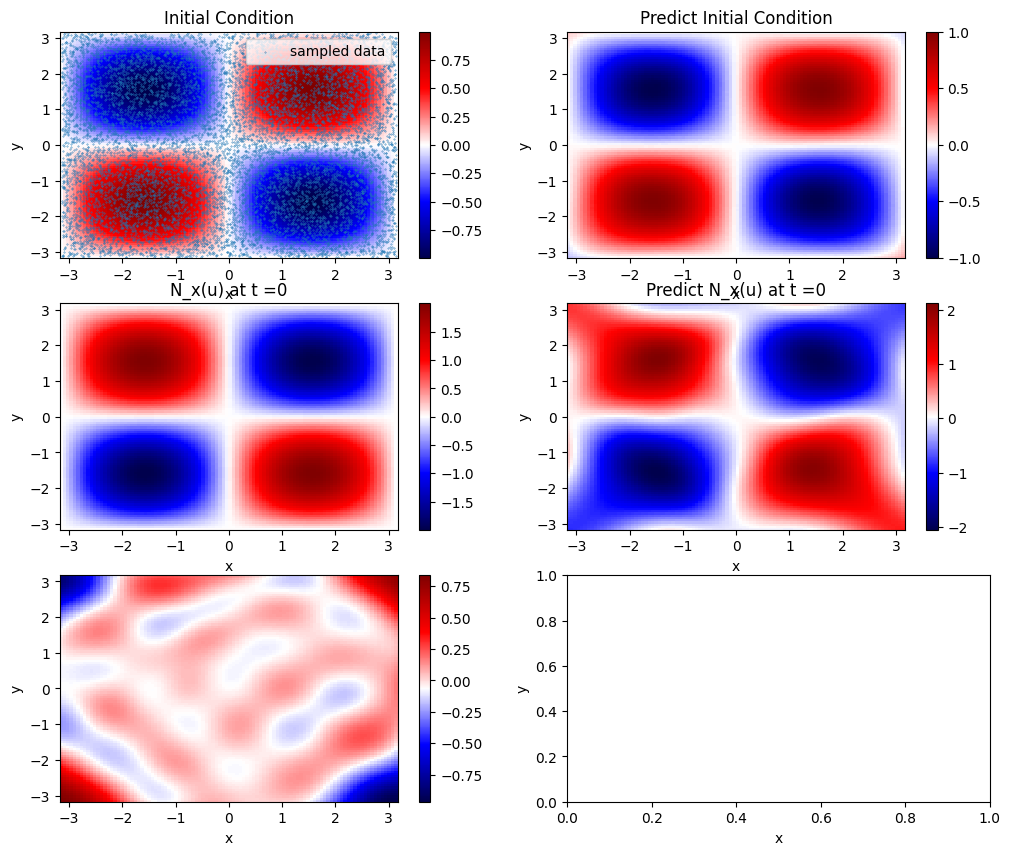

In [4]:
# Plotting
samp = Sampler(pde, nbatch)
data = samp.samp_init(key)
dinit = lambda x : - 2 * pde.params[0] * jnp.sin(x[0]) * jnp.sin(x[1])
dinit_pred = pde.spatial_diff_operator(evonnfit.get_nn())
dinit_diff = lambda x: dinit(x) - dinit_pred(x)
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(12,10))
axs = axes.ravel()
plot2D(fig, axs[0], pde.init_func, pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
plot2D(fig, axs[1], evonnfit.get_nn(), pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
plot2D(fig, axs[2], dinit, pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
plot2D(fig, axs[3], dinit_pred, pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
plot2D(fig, axs[4], dinit_diff, pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)

[a.set_title(t) for a, t in zip(axs, ["Initial Condition", "Predict Initial Condition", "N_x(u) at t =0", "Predict N_x(u) at t =0"])]
axs[0].scatter(data.x[:, 0], data.x[:, 1], s=0.1, label="sampled data")
axs[0].legend(loc='upper right')
[a.set_xlabel('x') for a in axs.ravel()];
[a.set_ylabel('y') for a in axs.ravel()];

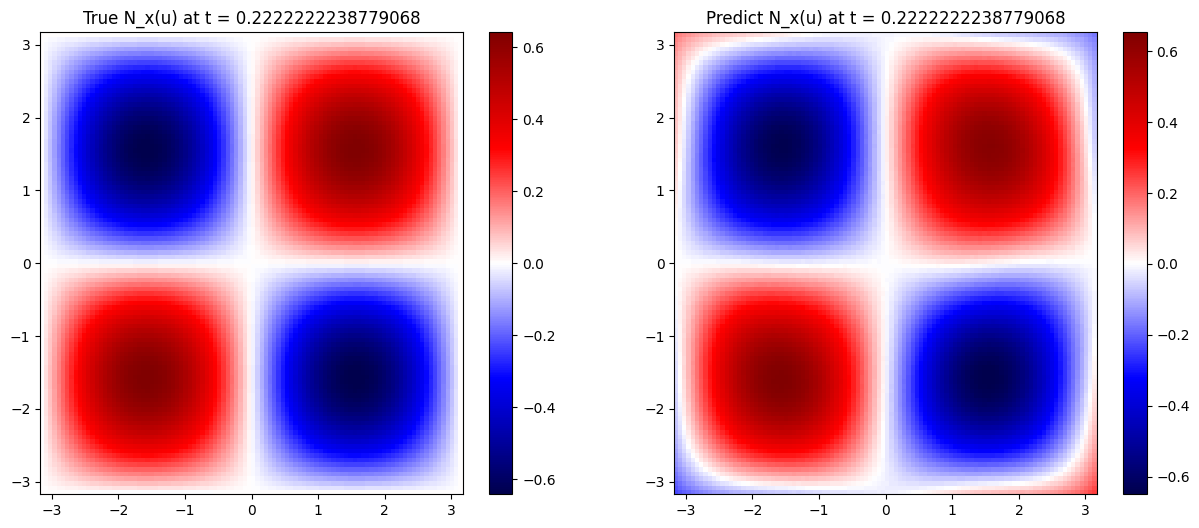

In [5]:
i = 2
w = sol.ys[i]
t = sol.ts[i]
fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax22 = ax2.ravel()
plot2D(fig2, ax22[0], lambda x: pde.u_true(x, t), pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
plot2D(fig2, ax22[1], evonnfit.new_w(w).get_nn(), pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
ax2[0].set_title(f"True N_x(u) at t = {t}")
ax2[1].set_title(f"Predict N_x(u) at t = {t}")
fig2.savefig("2dparabolic.png", dpi=300)

Text(0, 0.5, 'u')

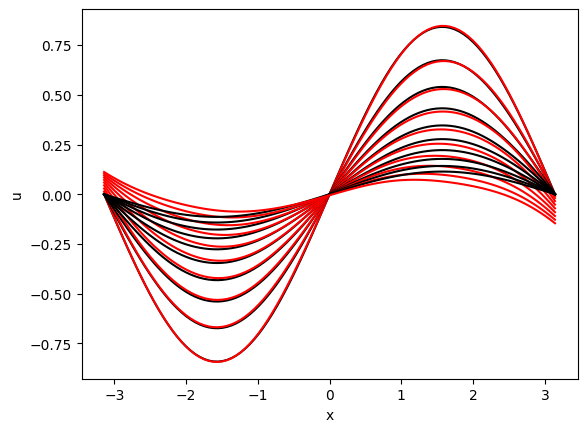

In [6]:
y = 1.0
xs = jnp.linspace(pde.xspan[0, 0], pde.xspan[1, 0], 100)
fig3, ax3 = plt.subplots()
for w, t in zip(sol.ys, sol.ts):

    nn = evonnfit.new_w(w).get_nn()
    u_trueF = lambda x: pde.u_true(jnp.array([x, y]), t)
    u_predF = lambda x: jnp.sum(nn(jnp.array([x, y])))

    u_true = jax.vmap(u_trueF)(xs)
    u_pred = jax.vmap(u_predF)(xs)
    ax3.plot(xs, u_true, color="black")
    ax3.plot(xs, u_pred, color="red")

ax3.set_xlabel("x")
ax3.set_ylabel("u")

Text(0, 0.5, 'u')

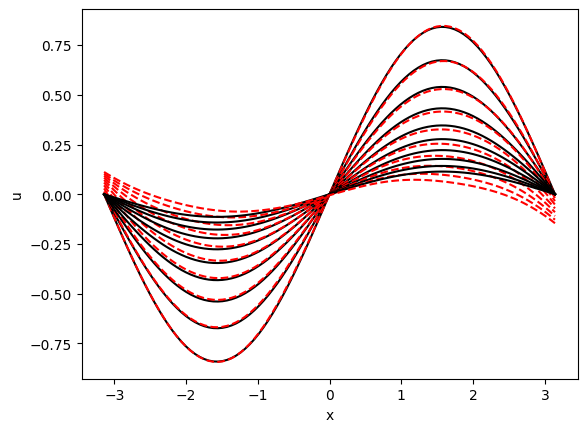

In [7]:
y = 1.0
xs = jnp.linspace(pde.xspan[0, 0], pde.xspan[1, 0], 100)
fig3, ax3 = plt.subplots()
for w, t in zip(sol.ys, sol.ts):

    nn = evonnfit.new_w(w).get_nn()
    u_trueF = lambda x: pde.u_true(jnp.array([x, y]), t)
    u_predF = lambda x: jnp.sum(nn(jnp.array([x, y])))

    u_true = jax.vmap(u_trueF)(xs)
    u_pred = jax.vmap(u_predF)(xs)
    ax3.plot(xs, u_true, color="black")
    ax3.plot(xs, u_pred, color="red", linestyle="--")

ax3.set_xlabel("x")
ax3.set_ylabel("u")

Text(0, 0.5, 'u')

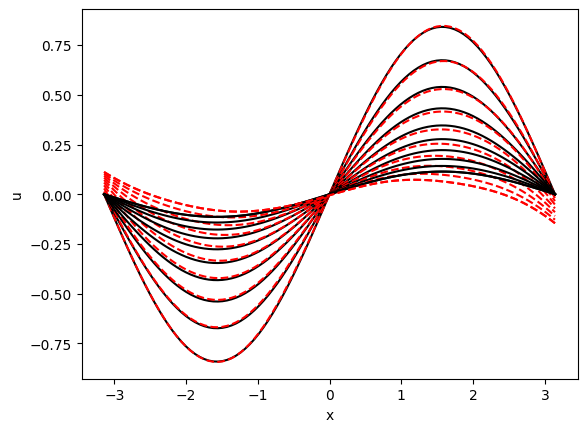

In [8]:
y = 1.0
xs = jnp.linspace(pde.xspan[0, 0], pde.xspan[1, 0], 100)
fig3, ax3 = plt.subplots()
for w, t in zip(sol.ys, sol.ts):

    nn = evonnfit.new_w(w).get_nn()
    u_trueF = lambda x: pde.u_true(jnp.array([x, y]), t)
    u_predF = lambda x: jnp.sum(nn(jnp.array([x, y])))

    u_true = jax.vmap(u_trueF)(xs)
    u_pred = jax.vmap(u_predF)(xs)
    ax3.plot(xs, u_true, color="black")
    ax3.plot(xs, u_pred, color="red", linestyle="--")

ax3.plot(xs, u_true, color="black", label="Analytical Sol.")
ax3.plot(xs, u_pred, color="red", linestyle="--", label="Prediction")
ax3.set_xlabel("x")
ax3.set_ylabel("u")

Text(0, 0.5, 'u')

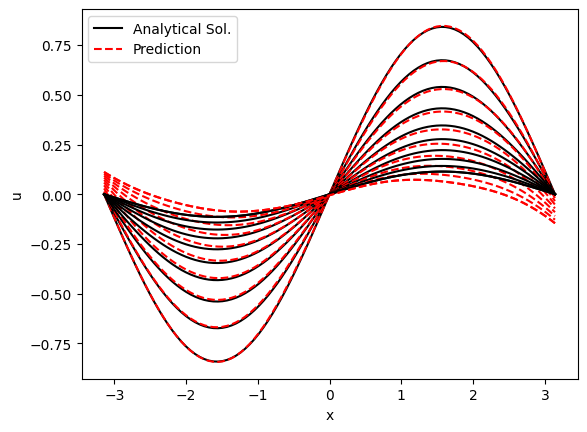

In [9]:
y = 1.0
xs = jnp.linspace(pde.xspan[0, 0], pde.xspan[1, 0], 100)
fig3, ax3 = plt.subplots()
for w, t in zip(sol.ys, sol.ts):

    nn = evonnfit.new_w(w).get_nn()
    u_trueF = lambda x: pde.u_true(jnp.array([x, y]), t)
    u_predF = lambda x: jnp.sum(nn(jnp.array([x, y])))

    u_true = jax.vmap(u_trueF)(xs)
    u_pred = jax.vmap(u_predF)(xs)
    ax3.plot(xs, u_true, color="black")
    ax3.plot(xs, u_pred, color="red", linestyle="--")

ax3.plot(xs, u_true, color="black", label="Analytical Sol.")
ax3.plot(xs, u_pred, color="red", linestyle="--", label="Prediction")
ax3.legend()
ax3.set_xlabel("x")
ax3.set_ylabel("u")

In [10]:
x = jnp.linspace(*xspan, ngrid)
y = jnp.linspace(*yspan, ngrid)
X, Y = jnp.meshgrid(x, y)
err = []
for w,t in zip(sol.ys, sol.ts):
    nn = evonnfit.new_w(w).get_nn()
    u_true = pde.u_true(jnp.array([X, Y]), t)
    u_pred = jax.vmap(jax.vmap(lambda x: jnp.sum(nn(x))))(X)
    error = jnp.norm(u_true - u_pred) / jnp.norm(u_true)
    err.append(error)

fig4, ax4 = plt.subplots()
ax4.plot(sol.ts, err)
ax4.set_title(f"Error at t = {t}")
fig4.savefig(f"error_{t}.png", dpi=300)

NameError: name 'xspan' is not defined

In [11]:
x = jnp.linspace(*pde.xspan.T[0], ngrid)
y = jnp.linspace(*pde.xspan.T[1], ngrid)
X, Y = jnp.meshgrid(x, y)
err = []
for w,t in zip(sol.ys, sol.ts):
    nn = evonnfit.new_w(w).get_nn()
    u_true = pde.u_true(jnp.array([X, Y]), t)
    u_pred = jax.vmap(jax.vmap(lambda x: jnp.sum(nn(x))))(X)
    error = jnp.norm(u_true - u_pred) / jnp.norm(u_true)
    err.append(error)

fig4, ax4 = plt.subplots()
ax4.plot(sol.ts, err)
ax4.set_title(f"Error at t = {t}")
fig4.savefig(f"error_{t}.png", dpi=300)

NameError: name 'ngrid' is not defined

In [12]:
x = jnp.linspace(*pde.xspan.T[0], 100)
y = jnp.linspace(*pde.xspan.T[1], 100)
X, Y = jnp.meshgrid(x, y)
err = []
for w,t in zip(sol.ys, sol.ts):
    nn = evonnfit.new_w(w).get_nn()
    u_true = pde.u_true(jnp.array([X, Y]), t)
    u_pred = jax.vmap(jax.vmap(lambda x: jnp.sum(nn(x))))(X)
    error = jnp.norm(u_true - u_pred) / jnp.norm(u_true)
    err.append(error)

fig4, ax4 = plt.subplots()
ax4.plot(sol.ts, err)
ax4.set_title(f"Error at t = {t}")
fig4.savefig(f"error_{t}.png", dpi=300)

ValueError: matmul input operand 1 must have ndim at least 1, but it has ndim 0

In [13]:
x = jnp.linspace(*pde.xspan.T[0], 100)
y = jnp.linspace(*pde.xspan.T[1], 100)
X, Y = jnp.meshgrid(x, y)
XY = jnp.stack([X.ravel(), Y.ravel()]).T
err = []
for w,t in zip(sol.ys, sol.ts):
    nn = evonnfit.new_w(w).get_nn()
    u_predf = lambda x: jnp.sum(nn(x))
    u_true = jax.vmap(pde.u_true, in_axes=(0,None))(XY, t)
    u_pred = jax.vmap(u_predf)(XY)
    error = jnp.norm(u_true - u_pred) / jnp.norm(u_true)
    err.append(error)

fig4, ax4 = plt.subplots()
ax4.plot(sol.ts, err)
ax4.set_title(f"Error at t = {t}")
fig4.savefig(f"error_{t}.png", dpi=300)

AttributeError: module 'jax.numpy' has no attribute 'norm'

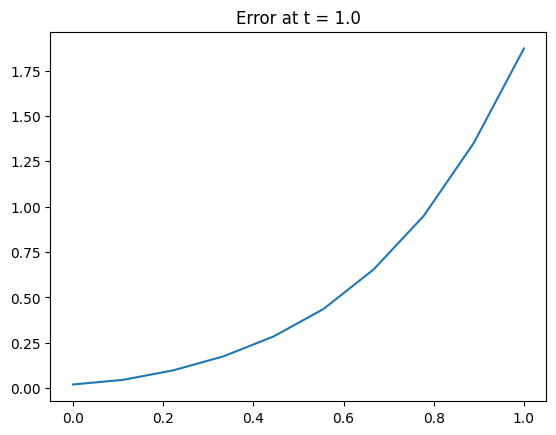

In [14]:
x = jnp.linspace(*pde.xspan.T[0], 100)
y = jnp.linspace(*pde.xspan.T[1], 100)
X, Y = jnp.meshgrid(x, y)
XY = jnp.stack([X.ravel(), Y.ravel()]).T
err = []
for w,t in zip(sol.ys, sol.ts):
    nn = evonnfit.new_w(w).get_nn()
    u_predf = lambda x: jnp.sum(nn(x))
    u_true = jax.vmap(pde.u_true, in_axes=(0,None))(XY, t)
    u_pred = jax.vmap(u_predf)(XY)
    error = jnp.linalg.norm(u_true - u_pred) / jnp.linalg.norm(u_true)
    err.append(error)

fig4, ax4 = plt.subplots()
ax4.plot(sol.ts, err)
ax4.set_title(f"Error at t = {t}")
fig4.savefig(f"error_{t}.png", dpi=300)

In [15]:
jnp.linalg.norm(jnp.array([1,2,3]))

Array(3.7416573, dtype=float32)

In [16]:
(1 + 4 + 9)**0.5

3.7416573867739413

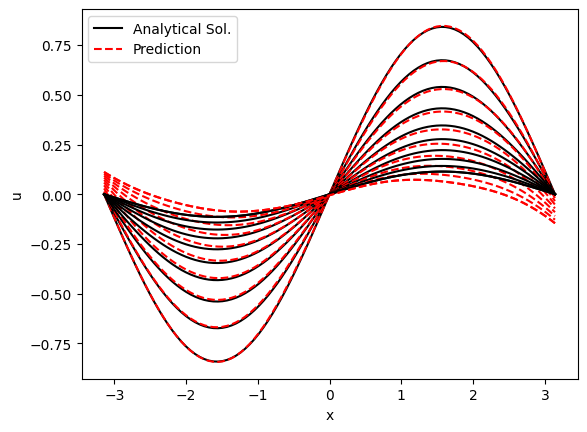

In [17]:
y = 1.0
xs = jnp.linspace(pde.xspan[0, 0], pde.xspan[1, 0], 100)
fig3, ax3 = plt.subplots()
for w, t in zip(sol.ys, sol.ts):

    nn = evonnfit.new_w(w).get_nn()
    u_trueF = lambda x: pde.u_true(jnp.array([x, y]), t)
    u_predF = lambda x: jnp.sum(nn(jnp.array([x, y])))

    u_true = jax.vmap(u_trueF)(xs)
    u_pred = jax.vmap(u_predF)(xs)
    ax3.plot(xs, u_true, color="black")
    ax3.plot(xs, u_pred, color="red", linestyle="--")

ax3.plot(xs, u_true, color="black", label="Analytical Sol.")
ax3.plot(xs, u_pred, color="red", linestyle="--", label="Prediction")
ax3.legend()
ax3.set_xlabel("x")
ax3.set_ylabel("u")
fig3.savefig("1dparabolic.png", dpi=300)

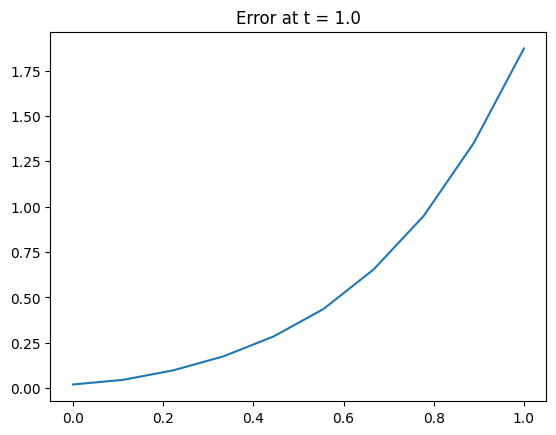

In [18]:
x = jnp.linspace(*pde.xspan.T[0], 100)
y = jnp.linspace(*pde.xspan.T[1], 100)
X, Y = jnp.meshgrid(x, y)
XY = jnp.stack([X.ravel(), Y.ravel()]).T
err = []
for w,t in zip(sol.ys, sol.ts):
    nn = evonnfit.new_w(w).get_nn()
    u_predf = lambda x: jnp.sum(nn(x))
    u_true = jax.vmap(pde.u_true, in_axes=(0,None))(XY, t)
    u_pred = jax.vmap(u_predf)(XY)
    error = jnp.linalg.norm(u_true - u_pred) / jnp.linalg.norm(u_true)
    err.append(error)

fig4, ax4 = plt.subplots()
ax4.plot(sol.ts, err)
ax4.set_title(f"Error at t = {t}")
fig4.savefig(f"error_{t}.png", dpi=300)

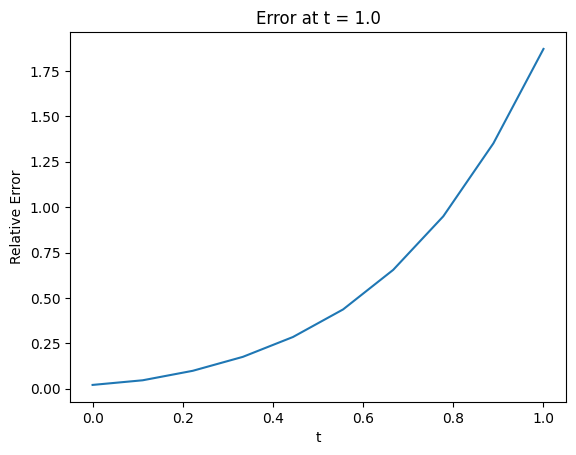

In [19]:
x = jnp.linspace(*pde.xspan.T[0], 100)
y = jnp.linspace(*pde.xspan.T[1], 100)
X, Y = jnp.meshgrid(x, y)
XY = jnp.stack([X.ravel(), Y.ravel()]).T
err = []
for w,t in zip(sol.ys, sol.ts):
    nn = evonnfit.new_w(w).get_nn()
    u_predf = lambda x: jnp.sum(nn(x))
    u_true = jax.vmap(pde.u_true, in_axes=(0,None))(XY, t)
    u_pred = jax.vmap(u_predf)(XY)
    error = jnp.linalg.norm(u_true - u_pred) / jnp.linalg.norm(u_true)
    err.append(error)

fig4, ax4 = plt.subplots()
ax4.plot(sol.ts, err)
ax4.set_xlabel("t")
ax4.set_ylabel("Relative Error")
ax4.set_title(f"Error at t = {t}")
fig4.savefig(f"error.png", dpi=300)

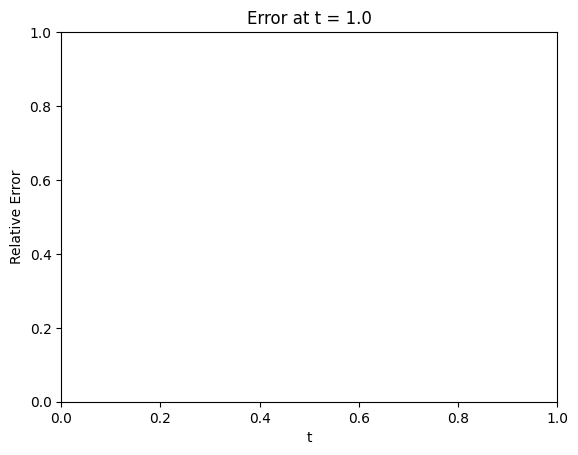

In [20]:
def plot_error(ax, sol, evon, pde, u_true):
    x = jnp.linspace(*pde.xspan.T[0], 100)
    y = jnp.linspace(*pde.xspan.T[1], 100)
    X, Y = jnp.meshgrid(x, y)
    XY = jnp.stack([X.ravel(), Y.ravel()]).T
    err = []
    for w,t in zip(sol.ys, sol.ts):
        nn = evonnfit.new_w(w).get_nn()
        u_predf = lambda x: jnp.sum(nn(x))
        u_true = jax.vmap(pde.u_true, in_axes=(0,None))(XY, t)
        u_pred = jax.vmap(u_predf)(XY)
        error = jnp.linalg.norm(u_true - u_pred) / jnp.linalg.norm(u_true)
        err.append(error)
    ax4.set_xlabel("t")
    ax4.set_ylabel("Relative Error")
    ax4.set_title(f"Error at t = {t}")

fig4, ax4 = plt.subplots()
plot_error(ax4, sol, evonnfit, pde, pde.u_true)
ax4.set_xlabel("t")
ax4.set_ylabel("Relative Error")
ax4.set_title(f"Error at t = {t}")
fig4.savefig(f"error.png", dpi=300)

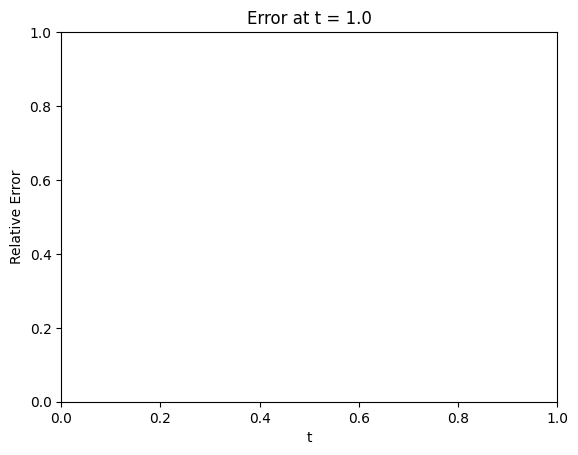

In [21]:
def plot_error(ax, sol, evon, pde, u_true):
    x = jnp.linspace(*pde.xspan.T[0], 100)
    y = jnp.linspace(*pde.xspan.T[1], 100)
    X, Y = jnp.meshgrid(x, y)
    XY = jnp.stack([X.ravel(), Y.ravel()]).T
    err = []
    for w,t in zip(sol.ys, sol.ts):
        nn = evonnfit.new_w(w).get_nn()
        u_predf = lambda x: jnp.sum(nn(x))
        u_true = jax.vmap(pde.u_true, in_axes=(0,None))(XY, t)
        u_pred = jax.vmap(u_predf)(XY)
        error = jnp.linalg.norm(u_true - u_pred) / jnp.linalg.norm(u_true)
        err.append(error)
    ax.set_xlabel("t")
    ax.set_ylabel("Relative Error")
    ax.set_title(f"Error at t = {t}")
    return ax

fig4, ax4 = plt.subplots()
plot_error(ax4, sol, evonnfit, pde, pde.u_true)
ax4.set_xlabel("t")
ax4.set_ylabel("Relative Error")
ax4.set_title(f"Error at t = {t}")
fig4.savefig(f"error.png", dpi=300)

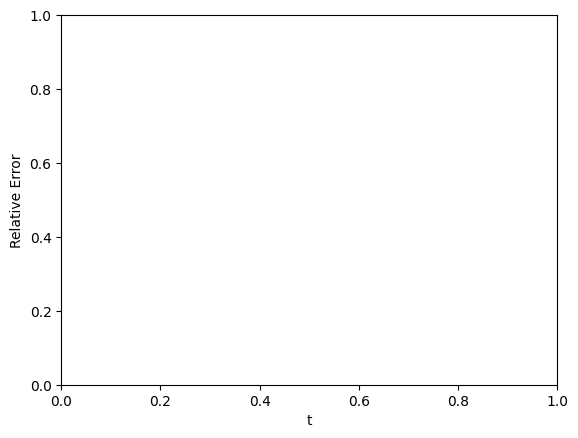

In [22]:
def plot_error(ax, sol, evon, pde, u_true):
    x = jnp.linspace(*pde.xspan.T[0], 100)
    y = jnp.linspace(*pde.xspan.T[1], 100)
    X, Y = jnp.meshgrid(x, y)
    XY = jnp.stack([X.ravel(), Y.ravel()]).T
    err = []
    for w,t in zip(sol.ys, sol.ts):
        nn = evonnfit.new_w(w).get_nn()
        u_predf = lambda x: jnp.sum(nn(x))
        u_true = jax.vmap(pde.u_true, in_axes=(0,None))(XY, t)
        u_pred = jax.vmap(u_predf)(XY)
        error = jnp.linalg.norm(u_true - u_pred) / jnp.linalg.norm(u_true)
        err.append(error)
    ax.set_xlabel("t")
    ax.set_ylabel("Relative Error")
    return ax

fig4, ax4 = plt.subplots()
plot_error(ax4, sol, evonnfit, pde, pde.u_true)
fig4.savefig(f"error.png", dpi=300)

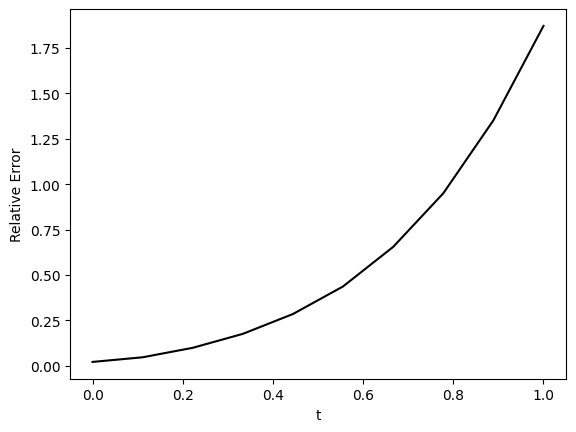

In [23]:
def plot_error(ax, sol, evon, pde, u_true, label=None):
    x = jnp.linspace(*pde.xspan.T[0], 100)
    y = jnp.linspace(*pde.xspan.T[1], 100)
    X, Y = jnp.meshgrid(x, y)
    XY = jnp.stack([X.ravel(), Y.ravel()]).T
    err = []
    for w,t in zip(sol.ys, sol.ts):
        nn = evonnfit.new_w(w).get_nn()
        u_predf = lambda x: jnp.sum(nn(x))
        u_true = jax.vmap(pde.u_true, in_axes=(0,None))(XY, t)
        u_pred = jax.vmap(u_predf)(XY)
        error = jnp.linalg.norm(u_true - u_pred) / jnp.linalg.norm(u_true)
        err.append(error)
    ax.plot(sol.ts, err, color="black", label=None)
    ax.set_xlabel("t")
    ax.set_ylabel("Relative Error")
    return ax

fig4, ax4 = plt.subplots()
plot_error(ax4, sol, evonnfit, pde, pde.u_true)
fig4.savefig(f"error.png", dpi=300)

In [24]:
term = dfx.ODETerm(evonnfit.ode)
solver = dfx.Bosh3()
stepsize_controller = dfx.PIDController(rtol=1e-5, atol=1e-5)
saveat = dfx.SaveAt(ts=np.linspace(pde.tspan[0], pde.tspan[-1], 10).tolist())
sol = dfx.diffeqsolve(term, solver, t0=pde.tspan[0], t1=pde.tspan[-1], dt0=0.1, y0=evonnfit.W, saveat=saveat, stepsize_controller=stepsize_controller, progress_meter=dfx.TqdmProgressMeter(refresh_steps=2))
#print(sol.ys)  

ValueError: `terms` must be a PyTree of `AbstractTerms` (such as `ODETerm`), with structure <class 'diffrax._term.AbstractTerm'>

Restarted evolutionalnn-ww6wOzNP-py3.10 (Python 3.10.12)

In [1]:
import jax 
jax.config.update("jax_enable_x64", False)
#jax.config.update("jax_debug_nans", True)
import equinox as eqx
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from typing import NamedTuple, Callable, Container
import abc
from tqdm.auto import tqdm
from tqdm import trange
import optax
import matplotlib.pyplot as plt
from functools import partial
import diffrax as dfx
import jaxopt

class Data(NamedTuple):
    x: jnp.ndarray
    y: jnp.ndarray

class PDE(eqx.Module):
    params: jnp.ndarray # parameters of the PDE
    xspan: jnp.ndarray # spatial domain
    tspan: jnp.ndarray # time domain
    @abc.abstractmethod
    def init_func(self, x):
        raise NotImplementedError
    @abc.abstractmethod
    def boundary_func(self, x):
        raise NotImplementedError
    @abc.abstractmethod
    def spatial_diff_operator(self, u_func): # u(x, )
        raise NotImplementedError

class ParabolicPDE2D(PDE):
    params: jnp.ndarray #[v]
    xspan: jnp.ndarray # spatial domain [[x_low, y_low], [x_high, y_high]]
    tspan: jnp.ndarray # time domain
    
    def init_func(self, x):
        return jnp.sin(x[0])* jnp.sin(x[1])
    
    def boundary_func(self, x):
        return jnp.array(0.)
    
    def spatial_diff_operator(self, func:Callable[[jnp.ndarray], float]): # u(x,y)-> u

        u_func = lambda x,y: jnp.sum(func(jnp.array([x,y])))

        ux = jax.grad(u_func, argnums=0)
        uxx = jax.grad(ux, argnums=0)
        uy = jax.grad(u_func, argnums=1)
        uyy = jax.grad(uy, argnums=1)
        v = self.params[0]
        Nx_func = lambda X: (uxx(X[0],X[1]) + uyy(X[0],X[1])) * v 
        return Nx_func
    
    def u_true(self, x, t):
        # Analytical solution: sin(x)sin(y)exp(-2vt)
        return jnp.sin(x[0]) * jnp.sin(x[1]) * jnp.exp(-2 * self.params[0] * t)

class Sampler(eqx.Module):
    pde: PDE
    batch: int
    samp_init: Callable[[jr.PRNGKey], Data]
    def __init__(self, pde, batch):
        self.pde = pde
        self.batch = batch
        dim = pde.xspan.shape[1]
        
        def samp_init(key):
            x = jr.uniform(key, (batch, dim), minval=self.pde.xspan[0], maxval=self.pde.xspan[1])
            y = jax.vmap(self.pde.init_func)(x)
            return Data(x,y)
        
        self.samp_init = jax.jit(samp_init)

class NNconstructor(eqx.Module):
    param_restruct: Callable[[jnp.ndarray], jnp.ndarray]
    nn_static: eqx.Module
    filter_spec: Container # spec for time evolution

    def __call__(self, W):
        nn_param = self.param_restruct(W)
        nn = eqx.combine(nn_param, self.nn_static)
        return nn

    def get_w(self, nn):
        nn_param, nn_static = eqx.partition(nn, self.filter_spec)
        W, param_restruct = jax.flatten_util.ravel_pytree(nn_param)
        return W

class EvolutionalNN(eqx.Module):
    W: jnp.ndarray
    pde: PDE
    nnconstructor: NNconstructor
    get_N: Callable[[jnp.ndarray, jnp.ndarray], jnp.ndarray]
    get_J: Callable[[jnp.ndarray, jnp.ndarray], jnp.ndarray]
    get_gamma: Callable[[jnp.ndarray, jnp.ndarray], jnp.ndarray]
    
    @classmethod
    def from_nn(cls, nn, pde, filter_spec=eqx.is_array):
        nn_param, nn_static = eqx.partition(nn, filter_spec)
        W, param_restruct = jax.flatten_util.ravel_pytree(nn_param)
        nnconstructor = NNconstructor(param_restruct, nn_static, filter_spec)

        @jax.jit
        def ufunc(W, xs):
            _nn = nnconstructor(W)
            u = lambda x: jnp.sum(_nn(x))
            us = jax.vmap(u)(xs)
            return us   # u(W, x)
        
        Jf =  jax.jacfwd(ufunc, argnums=0)

        @jax.jit
        def get_N(W, xs): #[batch, dim]
            # Spatial differential operator
            _nn = nnconstructor(W)
            nop = pde.spatial_diff_operator(_nn)
            return jax.vmap(nop)(xs)
        
        @jax.jit
        def get_J(W, xs):
            J = Jf(W, xs)
            return J

        # Define gamma method
        @jax.jit        
        def get_gamma(W, xs, tol=1e-5, **kwags):
            J = get_J(W, xs)
            N = get_N(W, xs)
            matvec = lambda x: jnp.dot(J.T @ J, x)
            gamma = jaxopt.linear_solve.solve_normal_cg(matvec, J.T @ N, tol=1e-5, **kwags)
            return gamma
            

        return cls(W, pde, nnconstructor, get_N, get_J, get_gamma)
    
    def new_w(self, W):
        return EvolutionalNN(W, self.pde, self.nnconstructor, self.get_N, self.get_J, self.get_gamma)

    def get_nn(self):
        return self.nnconstructor(self.W)
    
    def fit_initial(self, nbatch: int, nstep:int, optimizer, key: jr.PRNGKey, filter_spec=eqx.is_array, tol:float=1e-8):
        nn = self.get_nn()
        state = optimizer.init(eqx.filter(nn, filter_spec))
        sampler = Sampler(self.pde, nbatch)

        iter_step = trange(nstep)
        for i in iter_step:
            k_batch, key = jr.split(key)
            data = sampler.samp_init(k_batch) # sample initial function
            nn, state, loss = update_fn(nn, data, optimizer, state)
            iter_step.set_postfix({'loss':loss})
            if loss < tol:
                break
        return self.from_nn(nn, self.pde, self.nnconstructor.filter_spec)

    def ode (self, t,y, args):
        #jax.debug.print("y : {y}", y=y)
        gamma = self.get_gamma(y, xs)
        #jax.debug.print("Gamma : {gamma}", gamma=gamma)
        return gamma


@eqx.filter_jit
def update_fn(nn: eqx.Module, data:Data, optimizer, state):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(nn, data)
    updates, new_state = optimizer.update(grad, state, nn)
    new_nn = eqx.apply_updates(nn, updates)
    return new_nn, new_state, loss

def loss_fn(nn, data:Data):
    y_preds = jax.vmap(nn)(data.x)
    return jnp.mean(jnp.square(y_preds.ravel() - data.y.ravel()))


@eqx.filter_jit
def loop2d(arr1, arr2, fun):
    funcex = jax.jit(lambda x,y: fun(jnp.stack([x,y])))
    fj = jax.vmap(funcex, in_axes=(0,0))
    fi = jax.vmap(fj, in_axes=(0,0))
    return fi(arr1, arr2).reshape(arr1.shape)

def plot2D(fig, ax, func, xspan=(0,1), yspan=(0,1), ngrid=100):
    x = jnp.linspace(*xspan, ngrid)
    y = jnp.linspace(*yspan, ngrid)
    X, Y = jnp.meshgrid(x, y)
    Z =  loop2d(X, Y, func)
    bar = ax.pcolor(X, Y, Z, cmap='seismic')
    fig.colorbar(bar, ax=ax)
    
# Setup PDE 
key = jr.PRNGKey(0)
pde = ParabolicPDE2D(jnp.array([1.]), jnp.array([[-jnp.pi, -jnp.pi], [jnp.pi, jnp.pi]]), jnp.array([0., 1.]))



# Learn initial condition
opt = optax.adam(learning_rate=optax.exponential_decay(1e-4, 3000, 0.9, end_value=1e-9))
nbatch = 10000


evonn = EvolutionalNN.from_nn(eqx.nn.MLP(2, 1, 30, 4, activation=jnp.tanh,key=key), pde, eqx.is_array)
evonnfit = evonn.fit_initial(nbatch, 50000, opt, key)

/home/stevenchiu/.cache/pypoetry/virtualenvs/evolutionalnn-ww6wOzNP-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-14 11:14:00.994085: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
100%|██████████| 50000/50000 [00:52<00:00, 957.64it/s, loss=8.483196e-05]   


In [2]:
xspans = pde.xspan.T
gen_xgrid = lambda xspan: jnp.linspace(xspan[0], xspan[1], 65)
xs_grids = jax.vmap(gen_xgrid)(xspans)
Xg = jnp.meshgrid(*xs_grids)
xs = jnp.stack([Xg[i].ravel() for i in range(len(Xg))]).T

evonnfit.get_N(evonnfit.W, xs)
evonnfit.get_J(evonnfit.W, xs)

g = evonnfit.get_gamma(evonnfit.W, xs)
print(g)

[-0.00496716  0.07834226 -0.01783022 ...  0.03293452 -0.01890856
 -0.00285638]


In [3]:
term = dfx.ODETerm(evonnfit.ode)
solver = dfx.Bosh3()
stepsize_controller = dfx.PIDController(rtol=1e-5, atol=1e-5)
saveat = dfx.SaveAt(ts=np.linspace(pde.tspan[0], pde.tspan[-1], 10).tolist())
sol = dfx.diffeqsolve(term, solver, t0=pde.tspan[0], t1=pde.tspan[-1], dt0=0.1, y0=evonnfit.W, saveat=saveat, stepsize_controller=stepsize_controller, progress_meter=dfx.TqdmProgressMeter(refresh_steps=2))
#print(sol.ys)  

/home/stevenchiu/.cache/pypoetry/virtualenvs/evolutionalnn-ww6wOzNP-py3.10/lib/python3.10/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/stevenchiu/.cache/pypoetry/virtualenvs/evolutionalnn-ww6wOzNP-py3.10/lib/python3.10/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/stevenchiu/.cache/pypoetry/virtualenvs/evolutionalnn-ww6wOzNP-py3.10/lib/python3.10/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
100.00%|██████████| [00:11<00:00,  9.08%/s]


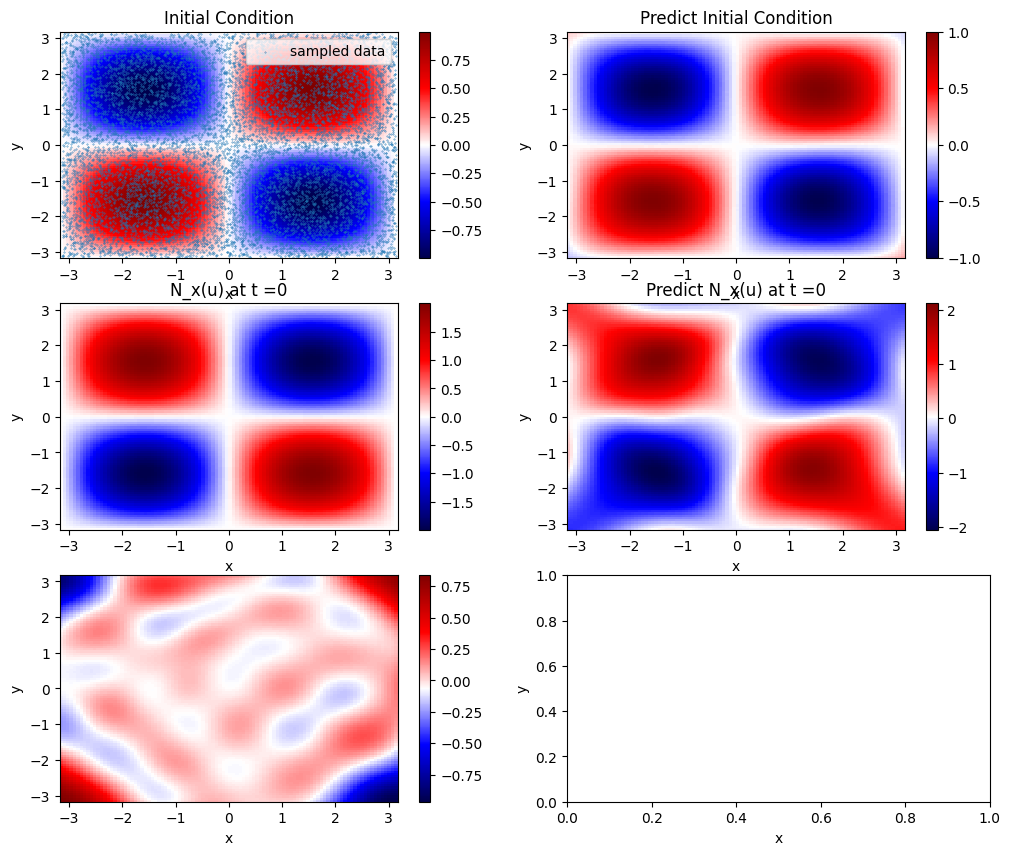

In [4]:
# Plotting
samp = Sampler(pde, nbatch)
data = samp.samp_init(key)
dinit = lambda x : - 2 * pde.params[0] * jnp.sin(x[0]) * jnp.sin(x[1])
dinit_pred = pde.spatial_diff_operator(evonnfit.get_nn())
dinit_diff = lambda x: dinit(x) - dinit_pred(x)
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(12,10))
axs = axes.ravel()
plot2D(fig, axs[0], pde.init_func, pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
plot2D(fig, axs[1], evonnfit.get_nn(), pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
plot2D(fig, axs[2], dinit, pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
plot2D(fig, axs[3], dinit_pred, pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
plot2D(fig, axs[4], dinit_diff, pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)

[a.set_title(t) for a, t in zip(axs, ["Initial Condition", "Predict Initial Condition", "N_x(u) at t =0", "Predict N_x(u) at t =0"])]
axs[0].scatter(data.x[:, 0], data.x[:, 1], s=0.1, label="sampled data")
axs[0].legend(loc='upper right')
[a.set_xlabel('x') for a in axs.ravel()];
[a.set_ylabel('y') for a in axs.ravel()];

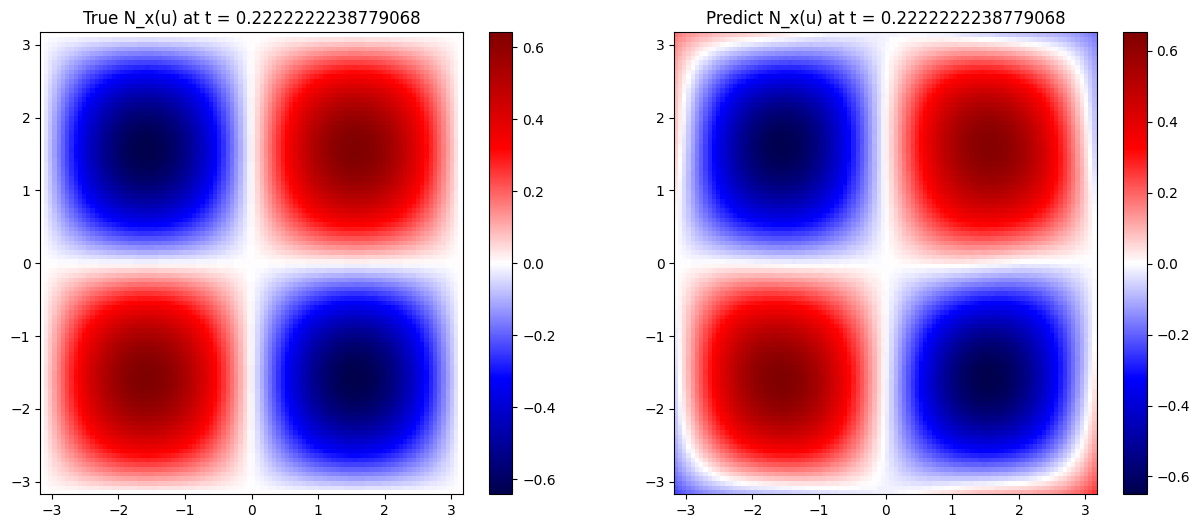

In [5]:
i = 2
w = sol.ys[i]
t = sol.ts[i]
fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax22 = ax2.ravel()
plot2D(fig2, ax22[0], lambda x: pde.u_true(x, t), pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
plot2D(fig2, ax22[1], evonnfit.new_w(w).get_nn(), pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
ax2[0].set_title(f"True N_x(u) at t = {t}")
ax2[1].set_title(f"Predict N_x(u) at t = {t}")
fig2.savefig("2dparabolic.png", dpi=300)

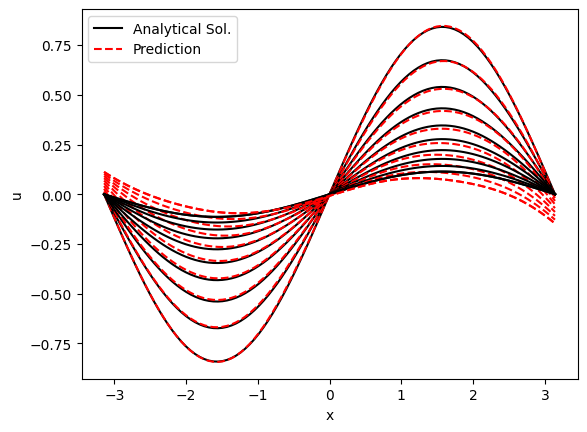

In [6]:
y = 1.0
xs = jnp.linspace(pde.xspan[0, 0], pde.xspan[1, 0], 100)
fig3, ax3 = plt.subplots()
for w, t in zip(sol.ys, sol.ts):

    nn = evonnfit.new_w(w).get_nn()
    u_trueF = lambda x: pde.u_true(jnp.array([x, y]), t)
    u_predF = lambda x: jnp.sum(nn(jnp.array([x, y])))

    u_true = jax.vmap(u_trueF)(xs)
    u_pred = jax.vmap(u_predF)(xs)
    ax3.plot(xs, u_true, color="black")
    ax3.plot(xs, u_pred, color="red", linestyle="--")

ax3.plot(xs, u_true, color="black", label="Analytical Sol.")
ax3.plot(xs, u_pred, color="red", linestyle="--", label="Prediction")
ax3.legend()
ax3.set_xlabel("x")
ax3.set_ylabel("u")
fig3.savefig("1dparabolic.png", dpi=300)

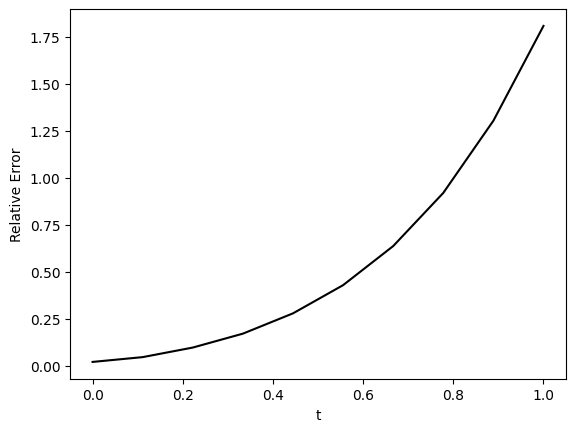

In [7]:
def plot_error(ax, sol, evon, pde, u_true, label=None):
    x = jnp.linspace(*pde.xspan.T[0], 100)
    y = jnp.linspace(*pde.xspan.T[1], 100)
    X, Y = jnp.meshgrid(x, y)
    XY = jnp.stack([X.ravel(), Y.ravel()]).T
    err = []
    for w,t in zip(sol.ys, sol.ts):
        nn = evonnfit.new_w(w).get_nn()
        u_predf = lambda x: jnp.sum(nn(x))
        u_true = jax.vmap(pde.u_true, in_axes=(0,None))(XY, t)
        u_pred = jax.vmap(u_predf)(XY)
        error = jnp.linalg.norm(u_true - u_pred) / jnp.linalg.norm(u_true)
        err.append(error)
    ax.plot(sol.ts, err, color="black", label=None)
    ax.set_xlabel("t")
    ax.set_ylabel("Relative Error")
    return ax

fig4, ax4 = plt.subplots()
plot_error(ax4, sol, evonnfit, pde, pde.u_true)
fig4.savefig(f"error.png", dpi=300)

NameError: name 'plot_sections' is not defined

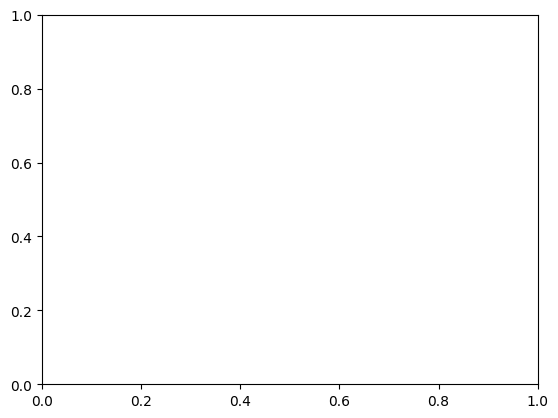

In [8]:
y = 1.0
xs = jnp.linspace(pde.xspan[0, 0], pde.xspan[1, 0], 100)
for w, t in zip(sol.ys, sol.ts):

    nn = evonnfit.new_w(w).get_nn()
    u_trueF = lambda x: pde.u_true(jnp.array([x, y]), t)
    u_predF = lambda x: jnp.sum(nn(jnp.array([x, y])))

    u_true = jax.vmap(u_trueF)(xs)
    u_pred = jax.vmap(u_predF)(xs)
    ax3.plot(xs, u_true, color="black")
    ax3.plot(xs, u_pred, color="red", linestyle="--")

ax3.plot(xs, u_true, color="black", label="Analytical Sol.")
ax3.plot(xs, u_pred, color="red", linestyle="--", label="Prediction")
ax3.legend()
ax3.set_xlabel("x")
ax3.set_ylabel("u")

fig3, ax3 = plt.subplots()
plot_sections(ax3, 2, sol, evonnfit, pde, pde.u_true)
fig3.savefig("1dparabolic.png", dpi=300)

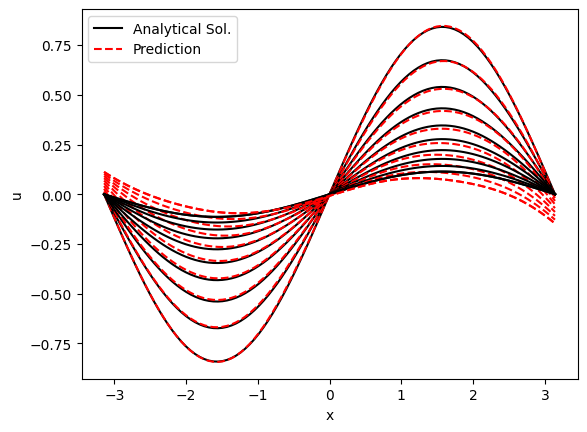

In [9]:
def plot_sections(ax, i, y, sol, evon, pde, u_true, label=None):
    w = sol.ys[i]
    t = sol.ts[i]
    xs = jnp.linspace(pde.xspan[0, 0], pde.xspan[1, 0], 100)
    for w, t in zip(sol.ys, sol.ts):

        nn = evonnfit.new_w(w).get_nn()
        u_trueF = lambda x: pde.u_true(jnp.array([x, y]), t)
        u_predF = lambda x: jnp.sum(nn(jnp.array([x, y])))

        u_true = jax.vmap(u_trueF)(xs)
        u_pred = jax.vmap(u_predF)(xs)
        ax3.plot(xs, u_true, color="black")
        ax3.plot(xs, u_pred, color="red", linestyle="--")

    ax3.plot(xs, u_true, color="black", label="Analytical Sol.")
    ax3.plot(xs, u_pred, color="red", linestyle="--", label="Prediction")
    ax3.legend()
    ax3.set_xlabel("x")
    ax3.set_ylabel("u")

fig3, ax3 = plt.subplots()
plot_sections(ax3, 2, 1., sol, evonnfit, pde, pde.u_true)
fig3.savefig("1dparabolic.png", dpi=300)

In [10]:
fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    ax22 = ax2.ravel()
    plot2D(fig2, ax22[0], lambda x: pde.u_true(x, t), pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
    plot2D(fig2, ax22[1], evonnfit.new_w(w).get_nn(), pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
    ax2[0].set_title(f"True N_x(u) at t = {t}")
    ax2[1].set_title(f"Predict N_x(u) at t = {t}")
    fig2.savefig("2dparabolic.png", dpi=300)

IndentationError: unexpected indent (<ipython-input-10-6b3dfa6fb85d>, line 3)

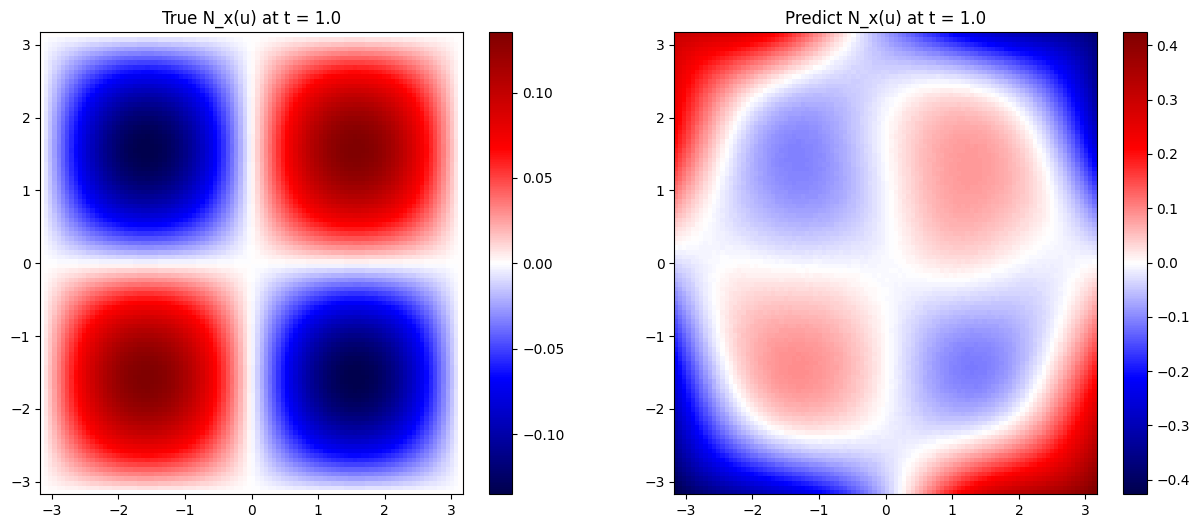

In [11]:
fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax22 = ax2.ravel()
plot2D(fig2, ax22[0], lambda x: pde.u_true(x, t), pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
plot2D(fig2, ax22[1], evonnfit.new_w(w).get_nn(), pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
ax2[0].set_title(f"True N_x(u) at t = {t}")
ax2[1].set_title(f"Predict N_x(u) at t = {t}")
fig2.savefig("2dparabolic.png", dpi=300)

In [12]:
t

Array(1., dtype=float32)

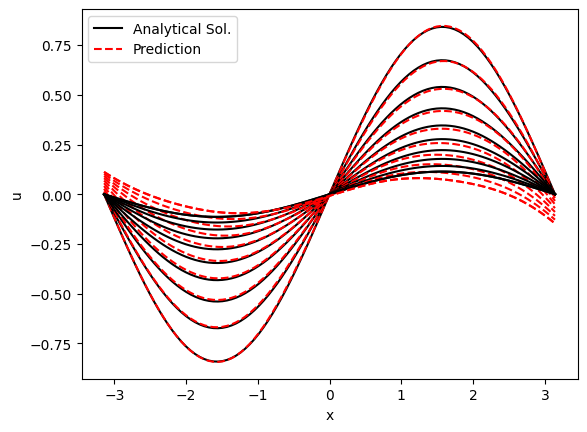

In [13]:
def plot_sections(ax, y, sol, evon, pde, u_true, label=None):
    xs = jnp.linspace(pde.xspan[0, 0], pde.xspan[1, 0], 100)
    for w, t in zip(sol.ys, sol.ts):

        nn = evonnfit.new_w(w).get_nn()
        u_trueF = lambda x: pde.u_true(jnp.array([x, y]), t)
        u_predF = lambda x: jnp.sum(nn(jnp.array([x, y])))

        u_true = jax.vmap(u_trueF)(xs)
        u_pred = jax.vmap(u_predF)(xs)
        ax3.plot(xs, u_true, color="black")
        ax3.plot(xs, u_pred, color="red", linestyle="--")

    ax3.plot(xs, u_true, color="black", label="Analytical Sol.")
    ax3.plot(xs, u_pred, color="red", linestyle="--", label="Prediction")
    ax3.legend()
    ax3.set_xlabel("x")
    ax3.set_ylabel("u")

fig3, ax3 = plt.subplots()
plot_sections(ax3, 1., sol, evonnfit, pde, pde.u_true)
fig3.savefig("1dparabolic.png", dpi=300)

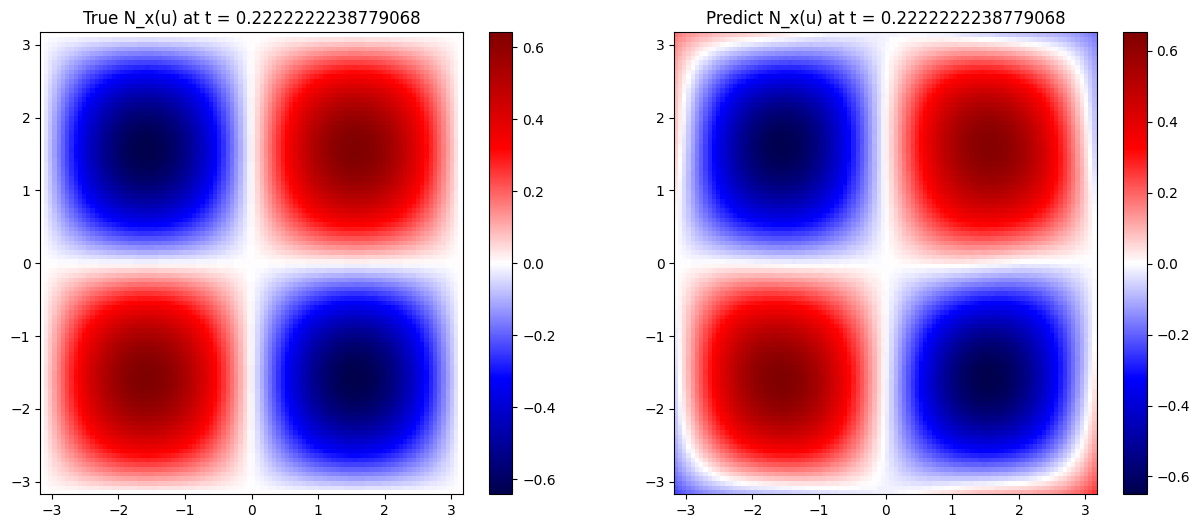

In [14]:
i = 2 
w = sol.ys[i]
t = sol.ts[i]
fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax22 = ax2.ravel()
plot2D(fig2, ax22[0], lambda x: pde.u_true(x, t), pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
plot2D(fig2, ax22[1], evonnfit.new_w(w).get_nn(), pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
ax2[0].set_title(f"True N_x(u) at t = {t}")
ax2[1].set_title(f"Predict N_x(u) at t = {t}")
fig2.savefig("2dparabolic.png", dpi=300)

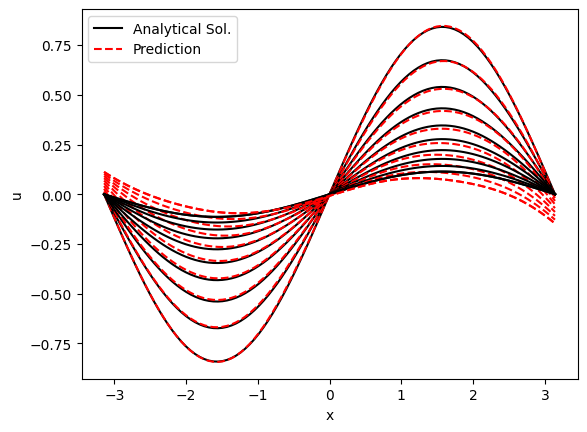

In [15]:
def plot_sections(ax, y, sol, evon, pde, u_true, label=None):
    xs = jnp.linspace(pde.xspan[0, 0], pde.xspan[1, 0], 100)
    for w, t in zip(sol.ys, sol.ts):

        nn = evonnfit.new_w(w).get_nn()
        u_trueF = lambda x: pde.u_true(jnp.array([x, y]), t)
        u_predF = lambda x: jnp.sum(nn(jnp.array([x, y])))

        u_true = jax.vmap(u_trueF)(xs)
        u_pred = jax.vmap(u_predF)(xs)
        ax3.plot(xs, u_true, color="black")
        ax3.plot(xs, u_pred, color="red", linestyle="--")

    ax3.plot(xs, u_true, color="black", label="Analytical Sol.")
    ax3.plot(xs, u_pred, color="red", linestyle="--", label="Prediction")
    ax3.legend()
    ax3.set_xlabel("x")
    ax3.set_ylabel("u")

fig3, ax3 = plt.subplots()
plot_sections(ax3, 1., sol, evonnfit, pde, pde.u_true)
fig3.savefig("1dparabolic.png", dpi=300)

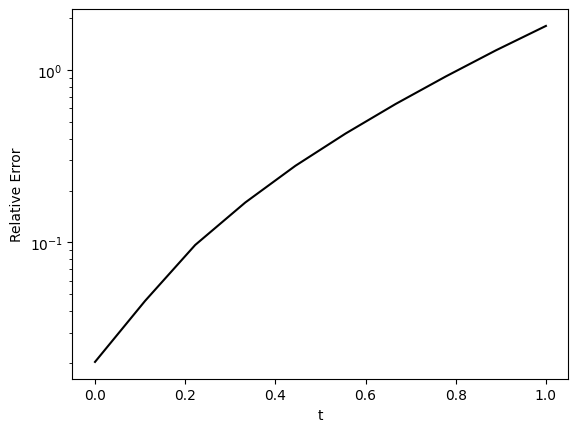

In [16]:
def plot_error(ax, sol, evon, pde, u_true, label=None):
    x = jnp.linspace(*pde.xspan.T[0], 100)
    y = jnp.linspace(*pde.xspan.T[1], 100)
    X, Y = jnp.meshgrid(x, y)
    XY = jnp.stack([X.ravel(), Y.ravel()]).T
    err = []
    for w,t in zip(sol.ys, sol.ts):
        nn = evonnfit.new_w(w).get_nn()
        u_predf = lambda x: jnp.sum(nn(x))
        u_true = jax.vmap(pde.u_true, in_axes=(0,None))(XY, t)
        u_pred = jax.vmap(u_predf)(XY)
        error = jnp.linalg.norm(u_true - u_pred) / jnp.linalg.norm(u_true)
        err.append(error)
    ax.plot(sol.ts, err, color="black", label=None)
    ax.set_xlabel("t")
    ax.set_ylabel("Relative Error")
    ax.set_yscale("log")
    return ax

fig4, ax4 = plt.subplots()
plot_error(ax4, sol, evonnfit, pde, pde.u_true)
fig4.savefig(f"error.png", dpi=300)

In [17]:
import jax 
jax.config.update("jax_enable_x64", False)
#jax.config.update("jax_debug_nans", True)
import equinox as eqx
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from typing import NamedTuple, Callable, Container
import abc
from tqdm.auto import tqdm
from tqdm import trange
import optax
import matplotlib.pyplot as plt
from functools import partial
import diffrax as dfx
import jaxopt

class Data(NamedTuple):
    x: jnp.ndarray
    y: jnp.ndarray

class PDE(eqx.Module):
    params: jnp.ndarray # parameters of the PDE
    xspan: jnp.ndarray # spatial domain
    tspan: jnp.ndarray # time domain
    @abc.abstractmethod
    def init_func(self, x):
        raise NotImplementedError
    @abc.abstractmethod
    def boundary_func(self, x):
        raise NotImplementedError
    @abc.abstractmethod
    def spatial_diff_operator(self, u_func): # u(x, )
        raise NotImplementedError


class DrichletNet(eqx.Module):
    nn: eqx.Module
    boundary_func: Callable[[jnp.ndarray], float]
    get_x_bounds: Callable[[], jnp.ndarray]

    def __init__(cls, pde, nn, ngrid=2):
        """Enforce Drichlet boundary condition
            ngrid (int, optional): Bound points on each edge. Defaults to 2.
        """
        xspans = pde.xspan.T
        gen_xgrid = lambda xspan: jnp.linspace(xspan[0], xspan[1], ngrid)
        xs_grids = jax.vmap(gen_xgrid)(xspans)

        self.nn = nn 
        self.boundary_func = pde.boundary_func
        self.get_x_bounds = lambda : xs_grids

    @staticmethod
    @jax.jit
    def get_coeffs(x, x_bounds):
        As = jax.vmap(dist, in_axes=(0, None))(x, x_bounds)
        Asmut = jnp.prod(As) 
        cs = jax.vmap(self.get_c, in_axes=(None, 0))(Asmut, As)
        return cs
    
    @eqx.filter_jit
    def __call__(self, x):
        x_bounds = self.get_x_bounds() # shape (n, dim)
        v_x = self.nn(x)
        v_x_bounds = jax.vmap(self.nn)(x_bounds)
        coeffs = self.get_coeffs(x, x_bounds)
        return v_x + jnp.inner(coeffs, v_x_bounds) + self.boundary_func(x)

@jax.jit
def dist(x1, x2):
    return jnp.linalg.norm(x1 - x2)

@jax.jit
def get_c(Asprod_all, a):
    Aprod = Asprod_all / a
    return - (Aprod / (Aprod + a))


class ParabolicPDE2D(PDE):
    params: jnp.ndarray #[v]
    xspan: jnp.ndarray # spatial domain [[x_low, y_low], [x_high, y_high]]
    tspan: jnp.ndarray # time domain
    
    def init_func(self, x):
        return jnp.sin(x[0])* jnp.sin(x[1])
    
    def boundary_func(self, x):
        return jnp.array(0.)
    
    def spatial_diff_operator(self, func:Callable[[jnp.ndarray], float]): # u(x,y)-> u

        u_func = lambda x,y: jnp.sum(func(jnp.array([x,y])))

        ux = jax.grad(u_func, argnums=0)
        uxx = jax.grad(ux, argnums=0)
        uy = jax.grad(u_func, argnums=1)
        uyy = jax.grad(uy, argnums=1)
        v = self.params[0]
        Nx_func = lambda X: (uxx(X[0],X[1]) + uyy(X[0],X[1])) * v 
        return Nx_func
    
    def u_true(self, x, t):
        # Analytical solution: sin(x)sin(y)exp(-2vt)
        return jnp.sin(x[0]) * jnp.sin(x[1]) * jnp.exp(-2 * self.params[0] * t)

class Sampler(eqx.Module):
    pde: PDE
    batch: int
    samp_init: Callable[[jr.PRNGKey], Data]
    def __init__(self, pde, batch):
        self.pde = pde
        self.batch = batch
        dim = pde.xspan.shape[1]
        
        def samp_init(key):
            x = jr.uniform(key, (batch, dim), minval=self.pde.xspan[0], maxval=self.pde.xspan[1])
            y = jax.vmap(self.pde.init_func)(x)
            return Data(x,y)
        
        self.samp_init = jax.jit(samp_init)

class NNconstructor(eqx.Module):
    param_restruct: Callable[[jnp.ndarray], jnp.ndarray]
    nn_static: eqx.Module
    filter_spec: Container # spec for time evolution

    def __call__(self, W):
        nn_param = self.param_restruct(W)
        nn = eqx.combine(nn_param, self.nn_static)
        return nn

    def get_w(self, nn):
        nn_param, nn_static = eqx.partition(nn, self.filter_spec)
        W, param_restruct = jax.flatten_util.ravel_pytree(nn_param)
        return W

class EvolutionalNN(eqx.Module):
    W: jnp.ndarray
    pde: PDE
    nnconstructor: NNconstructor
    get_N: Callable[[jnp.ndarray, jnp.ndarray], jnp.ndarray]
    get_J: Callable[[jnp.ndarray, jnp.ndarray], jnp.ndarray]
    get_gamma: Callable[[jnp.ndarray, jnp.ndarray], jnp.ndarray]
    
    @classmethod
    def from_nn(cls, nn, pde, filter_spec=eqx.is_array):
        nn_param, nn_static = eqx.partition(nn, filter_spec)
        W, param_restruct = jax.flatten_util.ravel_pytree(nn_param)
        nnconstructor = NNconstructor(param_restruct, nn_static, filter_spec)

        @jax.jit
        def ufunc(W, xs):
            _nn = nnconstructor(W)
            u = lambda x: jnp.sum(_nn(x))
            us = jax.vmap(u)(xs)
            return us   # u(W, x)
        
        Jf =  jax.jacfwd(ufunc, argnums=0)

        @jax.jit
        def get_N(W, xs): #[batch, dim]
            # Spatial differential operator
            _nn = nnconstructor(W)
            nop = pde.spatial_diff_operator(_nn)
            return jax.vmap(nop)(xs)
        
        @jax.jit
        def get_J(W, xs):
            J = Jf(W, xs)
            return J

        # Define gamma method
        @jax.jit        
        def get_gamma(W, xs, tol=1e-5, **kwags):
            J = get_J(W, xs)
            N = get_N(W, xs)
            matvec = lambda x: jnp.dot(J.T @ J, x)
            gamma = jaxopt.linear_solve.solve_normal_cg(matvec, J.T @ N, tol=1e-5, **kwags)
            return gamma
            

        return cls(W, pde, nnconstructor, get_N, get_J, get_gamma)
    
    def new_w(self, W):
        return EvolutionalNN(W, self.pde, self.nnconstructor, self.get_N, self.get_J, self.get_gamma)

    def get_nn(self):
        return self.nnconstructor(self.W)
    
    def fit_initial(self, nbatch: int, nstep:int, optimizer, key: jr.PRNGKey, filter_spec=eqx.is_array, tol:float=1e-8):
        nn = self.get_nn()
        state = optimizer.init(eqx.filter(nn, filter_spec))
        sampler = Sampler(self.pde, nbatch)

        iter_step = trange(nstep)
        for i in iter_step:
            k_batch, key = jr.split(key)
            data = sampler.samp_init(k_batch) # sample initial function
            nn, state, loss = update_fn(nn, data, optimizer, state)
            iter_step.set_postfix({'loss':loss})
            if loss < tol:
                break
        return self.from_nn(nn, self.pde, self.nnconstructor.filter_spec)

    def ode (self, t,y, args):
        #jax.debug.print("y : {y}", y=y)
        gamma = self.get_gamma(y, xs)
        #jax.debug.print("Gamma : {gamma}", gamma=gamma)
        return gamma


@eqx.filter_jit
def update_fn(nn: eqx.Module, data:Data, optimizer, state):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(nn, data)
    updates, new_state = optimizer.update(grad, state, nn)
    new_nn = eqx.apply_updates(nn, updates)
    return new_nn, new_state, loss

def loss_fn(nn, data:Data):
    y_preds = jax.vmap(nn)(data.x)
    return jnp.mean(jnp.square(y_preds.ravel() - data.y.ravel()))

    
# Setup PDE 
key = jr.PRNGKey(0)
pde = ParabolicPDE2D(jnp.array([1.]), jnp.array([[-jnp.pi, -jnp.pi], [jnp.pi, jnp.pi]]), jnp.array([0., 1.]))



# Learn initial condition
opt = optax.adam(learning_rate=optax.exponential_decay(1e-4, 3000, 0.9, end_value=1e-9))
nbatch = 10000

nn = DrichletNet(pde, eqx.nn.MLP(2, 1, 30, 4, activation=jnp.tanh,key=key), ngrid=2)
evonn = EvolutionalNN.from_nn(nn, pde, eqx.is_array)
evonnfit = evonn.fit_initial(nbatch, 50000, opt, key)

NameError: name 'self' is not defined

In [ ]:
xspans = pde.xspan.T
gen_xgrid = lambda xspan: jnp.linspace(xspan[0], xspan[1], 65)
xs_grids = jax.vmap(gen_xgrid)(xspans)
Xg = jnp.meshgrid(*xs_grids)
xs = jnp.stack([Xg[i].ravel() for i in range(len(Xg))]).T

evonnfit.get_N(evonnfit.W, xs)
evonnfit.get_J(evonnfit.W, xs)

g = evonnfit.get_gamma(evonnfit.W, xs)
print(g)

: 

In [ ]:
term = dfx.ODETerm(evonnfit.ode)
solver = dfx.Bosh3()
stepsize_controller = dfx.PIDController(rtol=1e-5, atol=1e-5)
saveat = dfx.SaveAt(ts=np.linspace(pde.tspan[0], pde.tspan[-1], 10).tolist())
sol = dfx.diffeqsolve(term, solver, t0=pde.tspan[0], t1=pde.tspan[-1], dt0=0.1, y0=evonnfit.W, saveat=saveat, stepsize_controller=stepsize_controller, progress_meter=dfx.TqdmProgressMeter(refresh_steps=2))
#print(sol.ys)  

: 

In [ ]:
# Plotting
@eqx.filter_jit
def loop2d(arr1, arr2, fun):
    funcex = jax.jit(lambda x,y: fun(jnp.stack([x,y])))
    fj = jax.vmap(funcex, in_axes=(0,0))
    fi = jax.vmap(fj, in_axes=(0,0))
    return fi(arr1, arr2).reshape(arr1.shape)

def plot2D(fig, ax, func, xspan=(0,1), yspan=(0,1), ngrid=100):
    x = jnp.linspace(*xspan, ngrid)
    y = jnp.linspace(*yspan, ngrid)
    X, Y = jnp.meshgrid(x, y)
    Z =  loop2d(X, Y, func)
    bar = ax.pcolor(X, Y, Z, cmap='seismic')
    fig.colorbar(bar, ax=ax)



samp = Sampler(pde, nbatch)
data = samp.samp_init(key)
dinit = lambda x : - 2 * pde.params[0] * jnp.sin(x[0]) * jnp.sin(x[1])
dinit_pred = pde.spatial_diff_operator(evonnfit.get_nn())
dinit_diff = lambda x: dinit(x) - dinit_pred(x)
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(12,10))
axs = axes.ravel()
plot2D(fig, axs[0], pde.init_func, pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
plot2D(fig, axs[1], evonnfit.get_nn(), pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
plot2D(fig, axs[2], dinit, pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
plot2D(fig, axs[3], dinit_pred, pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
plot2D(fig, axs[4], dinit_diff, pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)

[a.set_title(t) for a, t in zip(axs, ["Initial Condition", "Predict Initial Condition", "N_x(u) at t =0", "Predict N_x(u) at t =0"])]
axs[0].scatter(data.x[:, 0], data.x[:, 1], s=0.1, label="sampled data")
axs[0].legend(loc='upper right')
[a.set_xlabel('x') for a in axs.ravel()];
[a.set_ylabel('y') for a in axs.ravel()];

: 

In [ ]:
i = 2 
w = sol.ys[i]
t = sol.ts[i]
fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax22 = ax2.ravel()
plot2D(fig2, ax22[0], lambda x: pde.u_true(x, t), pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
plot2D(fig2, ax22[1], evonnfit.new_w(w).get_nn(), pde.xspan[:, 0], pde.xspan[:, 1], ngrid=100)
ax2[0].set_title(f"True N_x(u) at t = {t}")
ax2[1].set_title(f"Predict N_x(u) at t = {t}")
fig2.savefig("2dparabolic.png", dpi=300)

: 

In [ ]:
def plot_sections(ax, y, sol, evon, pde, u_true, label=None):
    xs = jnp.linspace(pde.xspan[0, 0], pde.xspan[1, 0], 100)
    for w, t in zip(sol.ys, sol.ts):

        nn = evonnfit.new_w(w).get_nn()
        u_trueF = lambda x: pde.u_true(jnp.array([x, y]), t)
        u_predF = lambda x: jnp.sum(nn(jnp.array([x, y])))

        u_true = jax.vmap(u_trueF)(xs)
        u_pred = jax.vmap(u_predF)(xs)
        ax3.plot(xs, u_true, color="black")
        ax3.plot(xs, u_pred, color="red", linestyle="--")

    ax3.plot(xs, u_true, color="black", label="Analytical Sol.")
    ax3.plot(xs, u_pred, color="red", linestyle="--", label="Prediction")
    ax3.legend()
    ax3.set_xlabel("x")
    ax3.set_ylabel("u")

fig3, ax3 = plt.subplots()
plot_sections(ax3, 1., sol, evonnfit, pde, pde.u_true)
fig3.savefig("1dparabolic.png", dpi=300)

: 

In [ ]:
def plot_error(ax, sol, evon, pde, u_true, label=None):
    x = jnp.linspace(*pde.xspan.T[0], 100)
    y = jnp.linspace(*pde.xspan.T[1], 100)
    X, Y = jnp.meshgrid(x, y)
    XY = jnp.stack([X.ravel(), Y.ravel()]).T
    err = []
    for w,t in zip(sol.ys, sol.ts):
        nn = evonnfit.new_w(w).get_nn()
        u_predf = lambda x: jnp.sum(nn(x))
        u_true = jax.vmap(pde.u_true, in_axes=(0,None))(XY, t)
        u_pred = jax.vmap(u_predf)(XY)
        error = jnp.linalg.norm(u_true - u_pred) / jnp.linalg.norm(u_true)
        err.append(error)
    ax.plot(sol.ts, err, color="black", label=None)
    ax.set_xlabel("t")
    ax.set_ylabel("Relative Error")
    ax.set_yscale("log")
    return ax

fig4, ax4 = plt.subplots()
plot_error(ax4, sol, evonnfit, pde, pde.u_true)
fig4.savefig(f"error.png", dpi=300)

: 